In [1]:
import glob
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt
from datetime import datetime
from IPython.display import clear_output
from pandas.core.common import flatten


import keras
import tensorflow
from pickle import dump
from pickle import load
import kerastuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [41]:
alarm = '1037_L'

In [42]:
def create_df(alarm_name):
    """ Returns a dataset of all valve values and specific alarm column."""
    
    dfs = {file.split("_")[-4]: pd.read_pickle(file) for file in \
           glob.glob("S:\SRH\BDBA_Sem_2\Case_study_1\data\*.pkl")}
    
    dfs_sorted = dict(sorted(dfs.items()))
    df_single = pd.concat(dfs_sorted, axis=0)
    
    alarms = ['1031_H', '1031_L', '1034_H', '1034_L', '1037_H', '1037_L']
    alarms.remove(alarm_name)
    
    df_alarm = df_single.drop(alarms, axis=1)
    df_alarm.fillna(0, inplace=True)
    
    spike_cols = [col for col in df_alarm.columns if alarm[:-2] in col]
    if "L" in alarm:
           spike_cols.pop(0)
    else:
        spike_cols.pop(1)
    df =  df_alarm.filter(spike_cols)
    
    return df
    

In [43]:
df_alarm = create_df(alarm)

In [44]:
def input_sequence(data, past_seq_len, future_window):
    """ Creates a small input sequence of a given seq length and 
        returns two numpy arrays as input and output sequence
        
        Args:
        data: input dataframe
        past_seq_len: integer number
        future_window: integer number

        """
    target_df = data.iloc[:,-1]
    input_x = []
    output_y = []
    for i in range(len(data) - past_seq_len -1):
        ins = data.iloc[i:(i+past_seq_len), 0:data.shape[1]-1]
        ots = np.where((target_df.iloc[(i+past_seq_len):(i+past_seq_len+future_window)]>0).any(), 1, 0)
        input_x.append(ins)
        output_y.append(ots)
    in_array = np.array(input_x).astype(np.float32)
    out_array = np.array(output_y).astype(np.float32)
    
    return in_array, out_array.reshape(-1,1)

In [45]:
def preprocessed_df(df, val_pct):
    """ Creates train, validation and test set after applying normalisation of all feature cols
    Args:
    df: dataframe object
    val_pct: percentage size of validation plus test size (float)
    """
    
    val_data_size = round(df.shape[0] * val_pct)
    test_data_size = round(val_data_size * 0.1)
    
    train_data = df[:-val_data_size]
    val_data = df[-val_data_size:-test_data_size]
    test_data = df[-test_data_size:]
    
    # Scaling the data
    scalar = MinMaxScaler()
    scalar.fit(train_data.iloc[:,:-1])
    # save the scaler
    dump(scalar, open('model_objects\scaler_cls_'+alarm+'.pkl', 'wb'))
    
    train_scaled = scalar.transform(train_data.iloc[:,:-1]) 
    val_scaled = scalar.transform(val_data.iloc[:,:-1])
    test_scaled = scalar.transform(test_data.iloc[:,:-1])
    
    df_train = pd.DataFrame(train_scaled)
    df_train['alarm'] = train_data.iloc[:,-1].values
    df_val = pd.DataFrame(val_scaled)
    df_val['alarm'] = val_data.iloc[:,-1].values
    df_test = pd.DataFrame(test_scaled)
    df_test['alarm'] = test_data.iloc[:,-1].values
    
    return df_train, df_val, df_test

In [46]:
df_train, df_val, df_test = preprocessed_df(df_alarm, 0.3)

In [84]:
# specify the window size
n_steps = 15
future_window = 10
# split into samples
X_train, y_train = input_sequence(df_train, n_steps, future_window)
X_val, y_val = input_sequence(df_val, n_steps, future_window)
X_test, y_test = input_sequence(df_test, n_steps, future_window)

### DON"T  RUN MODEL GET MODEL FROM SAVED OBJECT

In [9]:
#Build Model
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(100, kernel_initializer='he_normal',input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))


# compile the model
model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# configure early stopping
es = EarlyStopping(monitor='val_loss', patience=8)

# Visualise model
logdir = "logs/ts_classification_"+alarm+"/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=logdir)

# Create a callback that saves the model's weights
checkpoint_filepath = './tmp'+alarm+'/checkpoint'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# fit the model
model_history = model.fit(X_train, y_train, epochs=250, 
                          batch_size=32, verbose=2, 
                          validation_data=(X_val, y_val), 
                          callbacks=[es, tensorboard, model_checkpoint])

Epoch 1/250
522/522 - 18s - loss: 0.5890 - accuracy: 0.7427 - val_loss: 0.5706 - val_accuracy: 0.7231
Epoch 2/250
522/522 - 12s - loss: 0.5316 - accuracy: 0.7814 - val_loss: 0.5396 - val_accuracy: 0.7325
Epoch 3/250
522/522 - 11s - loss: 0.5210 - accuracy: 0.7900 - val_loss: 0.5626 - val_accuracy: 0.7342
Epoch 4/250
522/522 - 12s - loss: 0.5158 - accuracy: 0.7909 - val_loss: 0.6473 - val_accuracy: 0.7244
Epoch 5/250
522/522 - 12s - loss: 0.5102 - accuracy: 0.7953 - val_loss: 0.5601 - val_accuracy: 0.7356
Epoch 6/250


KeyboardInterrupt: 

In [85]:
# Loads the weights
model.load_weights('./tmp'+alarm+'/checkpoint')

# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Test accuracy: {:5.2f}%".format(100 * acc))

22/22 - 0s - loss: 0.3409 - accuracy: 0.8984
Test accuracy: 89.84%


In [86]:
# yhat = model.predict_classes(X_test)
yhat = model.predict(X_test).argmax(axis=-1)

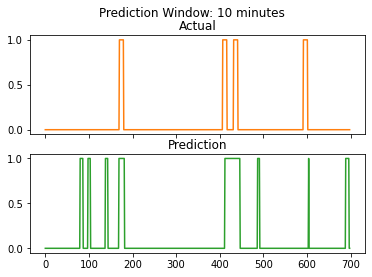

In [87]:
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle(f'Prediction Window: {future_window} minutes\n')
axs[0].plot(y_test, 'tab:orange')
axs[0].set_title("Actual")
axs[1].plot(yhat, 'tab:green')
axs[1].set_title("Prediction")
plt.savefig(f'{alarm}_univeriate_classification_{future_window}.png')